In [1]:
# %matplotlib inline 


# 1) Wipe out your namespace
%reset -f

# 2) Clear Jupyter’s stored outputs (and inputs if you like)
try:
    Out.clear()
except NameError:
    pass

try:
    In.clear()
except NameError:
    pass

# 3) Force Python GC
import gc
gc.collect()

# 4) Free any GPU buffers
import torch
if torch.cuda.is_available():
    torch.cuda.empty_cache()


import importlib
from libs import params, trades, feats, plots, models_core, models_custom
importlib.reload(params)
importlib.reload(trades)
importlib.reload(feats)
importlib.reload(plots)
importlib.reload(models_core)
importlib.reload(models_custom)

<module 'libs.models_custom' from '/workspace/my_models/Trading/_Stock_Analysis_/libs/models_custom.py'>

In [2]:
import pandas as pd
pd.set_option('display.max_columns', None)

import numpy as np
import math

from pathlib import Path
import pickle
import datetime as dt
from datetime import datetime, time, timedelta

import matplotlib.pyplot as plt   
import seaborn as sns
from pprint import pprint

import torch.nn.functional as Funct
from torch.utils.data import Dataset, DataLoader
torch.serialization.add_safe_globals([models_core.DayWindowDataset])
import torchmetrics

from tqdm.auto import tqdm
from typing import Tuple, Set, List, Union, Dict

import io
from PIL import Image
import IPython.display as disp

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    mean_squared_error,
    mean_absolute_error,
    r2_score,
)


Selected checkpoint: trainings/AAPL_0.10347_fin.pth

Hyperparameters:
{'ALPHA_SMOOTH': 0,
 'CLIPNORM': 3,
 'CONV_CHANNELS': 64,
 'CONV_DILATION': 1,
 'CONV_K': 3,
 'DROPOUT_LONG': 0.1,
 'DROPOUT_SHORT': 0.1,
 'DROPOUT_TRANS': 0.03,
 'EARLY_STOP_PATIENCE': 9,
 'FLATTEN_MODE': 'attn',
 'HEAD_LR_PCT': 1,
 'HUBER_DELTA': 0.1,
 'LAMBDA_DELTA': 0.1,
 'LONG_UNITS': 64,
 'LOOK_BACK': 60,
 'MAX_EPOCHS': 90,
 'MICRO_SAMPLE_K': 16,
 'ONECYCLE_DIV_FACTOR': 10,
 'ONECYCLE_FINAL_DIV': 100,
 'ONECYCLE_MAX_LR': 0.0003,
 'ONECYCLE_PCT_START': 0.1,
 'ONECYCLE_STRATEGY': 'cos',
 'PRED_HIDDEN': 96,
 'SHORT_UNITS': 64,
 'TCN_CHANNELS': 64,
 'TCN_KERNEL': 3,
 'TCN_LAYERS': 1,
 'TRAIN_BATCH': 16,
 'TRAIN_PREFETCH_FACTOR': 4,
 'TRAIN_WORKERS': 8,
 'TRANSFORMER_D_MODEL': 64,
 'TRANSFORMER_FF_MULT': 4,
 'TRANSFORMER_HEADS': 4,
 'TRANSFORMER_LAYERS': 3,
 'USE_CONV': False,
 'USE_DELTA': False,
 'USE_HUBER': False,
 'USE_LONG_LSTM': False,
 'USE_SHORT_LSTM': False,
 'USE_TCN': False,
 'USE_TRANSFORMER': True,
 'V

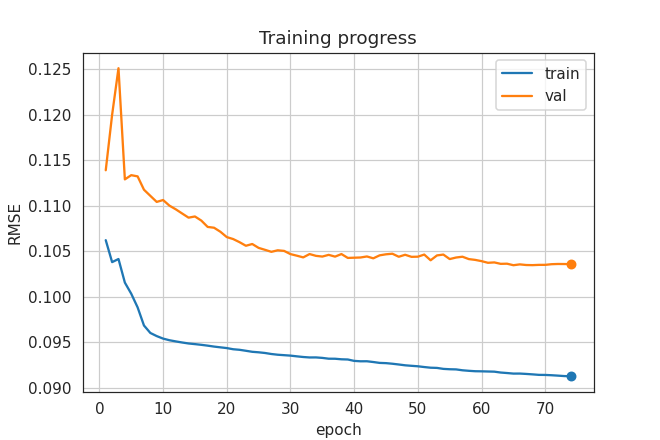


Train metrics: {'rmse': 0.09126676533298515, 'mae': 0.059888607436241, 'r2': 0.20947517688641792}
 Val metrics: {'rmse': 0.10359673742475829, 'mae': 0.06947842638527826, 'r2': 0.1701392668139532}


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:375: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


ModelClass(
  (conv): Identity()
  (bn): Identity()
  (relu): ReLU()
  (tcn): Identity()
  (ln_short): Identity()
  (do_short): Identity()
  (input_proj): Linear(in_features=70, out_features=70, bias=True)
  (feature_proj): Linear(in_features=70, out_features=64, bias=True)
  (pos_enc): PositionalEncoding(
    (dropout): Dropout(p=0.03, inplace=False)
  )
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0-2): 3 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
        (linear1): Linear(in_features=64, out_features=256, bias=True)
        (dropout): Dropout(p=0.03, inplace=False)
        (linear2): Linear(in_features=256, out_features=64, bias=True)
        (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.03, inplace=False)
     

In [3]:
fname = f"{params.ticker}_{params.sel_val_rmse}_fin.pth"
model_path = Path(params.models_folder) / fname

print("Selected checkpoint:", model_path)

# Load the on-disk dict (all tensors on CPU, no code executed)
ckpt = torch.load(model_path, map_location="cpu", weights_only=False)

# Inspect metadata, plots, metrics
print("\nHyperparameters:")
pprint(ckpt["hparams"])

model_feats = ckpt['features']
print("\nFeatures:")
print(model_feats)

if "train_plot_png" in ckpt:
    img = Image.open(io.BytesIO(ckpt["train_plot_png"]))
    display(img)

print("\nTrain metrics:", ckpt["train_metrics"])
print(  " Val metrics:", ckpt["val_metrics"])

# Reinstantiate a *clean* model in CPU memory
model_choice = models_custom.ModelClass(
    n_feats             = len(model_feats),
    short_units         = ckpt["hparams"]["SHORT_UNITS"],
    long_units          = ckpt["hparams"]["LONG_UNITS"],
    transformer_d_model = ckpt["hparams"]["TRANSFORMER_D_MODEL"],
    transformer_layers  = ckpt["hparams"]["TRANSFORMER_LAYERS"],
    dropout_short       = ckpt["hparams"]["DROPOUT_SHORT"],
    dropout_long        = ckpt["hparams"]["DROPOUT_LONG"],
    dropout_trans       = ckpt["hparams"]["DROPOUT_TRANS"],
    pred_hidden         = ckpt["hparams"]["PRED_HIDDEN"],
    look_back           = ckpt["hparams"]["LOOK_BACK"],

    # Gating flags
    use_conv            = ckpt["hparams"]["USE_CONV"],
    use_tcn             = ckpt["hparams"]["USE_TCN"],
    use_short_lstm      = ckpt["hparams"]["USE_SHORT_LSTM"],
    use_transformer     = ckpt["hparams"]["USE_TRANSFORMER"],
    use_long_lstm       = ckpt["hparams"]["USE_LONG_LSTM"],
    use_delta           = ckpt["hparams"]["USE_DELTA"],
    flatten_mode        = ckpt["hparams"]["FLATTEN_MODE"]
)

# Load *only* the weight tensors into that fresh model
model_choice.load_state_dict(ckpt["model_state_dict"])
model_choice.to(params.device)
model_choice.eval()

model_choice


In [4]:
df_model_feats = pd.read_csv(params.feat_all_csv, index_col=0, parse_dates=True)[model_feats + ['close_raw'] + [params.label_col]]
    
df_model_feats

/tmp/ipykernel_229/2900614286.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_model_feats = pd.read_csv(params.feat_all_csv, index_col=0, parse_dates=True)[model_feats + ['close_raw'] + [params.label_col]]


KeyError: "['dist_low_28', 'dist_high_28', 'sma_pct_14', 'roc_14', 'sma_pct_28', 'roc_28', 'signal'] not in index"

In [ ]:
importlib.reload(params)
importlib.reload(models_core)

train_loader, val_loader, test_loader, end_times_tr, end_times_val, end_times_te = models_core.model_core_pipeline(
    df              = df_model_feats,
    look_back       = params.hparams["LOOK_BACK"],
    sess_start      = params.sess_start_shift,
    train_batch     = params.hparams["TRAIN_BATCH"],
    train_workers   = params.hparams["TRAIN_WORKERS"],
    prefetch_factor = params.hparams["TRAIN_PREFETCH_FACTOR"],
    return_thresh   = params.return_thresh_tick # TBD
)


In [ ]:
# for name, ld, tm in zip(
#     ["train","val","test"],
#     [train_loader, val_loader, test_loader],
#     [end_times_tr, end_times_val, end_times_te]
# ):
#     models_core.summarize_split(name, ld, tm)

In [ ]:
y_val = np.concatenate([batch[1].cpu().numpy().ravel() for batch in val_loader])
y_test = np.concatenate([batch[1].cpu().numpy().ravel() for batch in test_loader])

# Visualize the true‐signal distributions on validation vs. test
plt.hist(y_val,   bins=100, alpha=0.5, label="val true")
plt.hist(y_test, bins=100, alpha=0.5, label="test true")

plt.xlabel("Signal value")
plt.ylabel("Count")
plt.title("True Signal Distribution: Validation vs Test")
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
importlib.reload(models_custom) ########

print('Calculating Train metrics and predictions...')
train_metrics, _, train_preds, _, _ = \
    models_custom.eval_on_loader(train_loader, model_choice)

print('Calculating Val metrics and predictions...')
val_metrics, _, val_preds, _, _  = \
    models_custom.eval_on_loader(val_loader,   model_choice)

print('Calculating Test metrics and predictions...')
test_metrics, _, test_preds, _, _ = \
    models_custom.eval_on_loader(test_loader,  model_choice)


# Simple summary
print("=== SIMPLE SUMMARY ===\n")

print("Predictions lengths:")
print(f"  Train : {len(train_preds)}")
print(f"  Valid : {len(val_preds)}")
print(f"  Test  : {len(test_preds)}\n")

print("Metrics:")
print(f"  Train → RMSE={train_metrics['rmse']:.5f}, MAE={train_metrics['mae']:.5f}, R²={train_metrics['r2']:.5f}")
print(f"  Valid → RMSE={val_metrics['rmse']:.5f}, MAE={val_metrics['mae']:.5f}, R²={val_metrics['r2']:.5f}")
print(f"  Test  → RMSE={test_metrics['rmse']:.5f}, MAE={test_metrics['mae']:.5f}, R²={test_metrics['r2']:.5f}\n")

print("Predictions stats (mean±std):")
print(f"  Train : {train_preds.mean():.5f} ± {train_preds.std():.5f}")
print(f"  Valid : {val_preds.mean():.5f} ± {val_preds.std():.5f}")
print(f"  Test  : {test_preds.mean():.5f} ± {test_preds.std():.5f}")


In [ ]:
# importlib.reload(models_custom)

# 1) Stamp predictions and mid‐price, then split into train+val & test
df_trainval, df_test = models_custom.add_preds_and_split( 
    df            = df_model_feats,
    train_preds   = train_preds,
    val_preds     = val_preds,
    test_preds    = test_preds,
    end_times_tr  = end_times_tr,
    end_times_val = end_times_val,
    end_times_te  = end_times_te
)

df_test

In [ ]:
# Pearson corr between each feature and the pred_signal on the test split

# Identify feature columns (drop non-inputs)
feat_cols = [
    c for c in df_test.columns
    if c not in ("bid","ask","signal","pred_signal","close_raw")
]

# Compute absolute corr(feature, pred_signal)
corrs = df_test[feat_cols] \
    .corrwith(df_test["pred_signal"]) \
    .abs() \
    .sort_values(ascending=False)

# Bar plot
corrs.plot.bar(figsize=(8,4), title="|corr| vs. pred_signal")
plt.ylabel("abs(pearson corr)")
plt.tight_layout()
plt.show()

corrs

In [ ]:
# Descriptive Statistics shows whether the model systematically over/under-estimates (compare means) and how tightly it tracks (std & correlation).

# assume df is your DataFrame
stats = df_test[['signal','pred_signal']].describe().T

# add range and error
stats['range'] = stats['max'] - stats['min']
corr = df_test['signal'].corr(df_test['pred_signal'])
stats['pearson_r_with_other'] = [corr, corr]

stats

In [ ]:
# Histogram overlay reveals any bias or mismatched shape in the two distributions.

plt.figure(figsize=(8,4))
sns.histplot(df_test['signal'], color='C0', alpha=0.5, bins=50, label='signal')
sns.histplot(df_test['pred_signal'],   color='C1', alpha=0.5, bins=50, label='pred_signal')
plt.legend()
plt.xlabel('Signal Value')
plt.ylabel('Count')
plt.title('Histogram of true signal vs. pred signal')
plt.show()

In [ ]:
# Scatter Plot: Relationship
# Scatter against the 45° line instantly shows under/over‐prediction regions and non‐linear errors.

plt.figure(figsize=(5,5))
plt.scatter(df_test['signal'], df_test['pred_signal'],
            s=5, alpha=0.3, color='C2')
plt.plot([0,1],[0,1], 'k--', linewidth=1)  # 45° reference line
plt.xlabel('signal')
plt.ylabel('pred_signal')
plt.title('pred signal vs. true signal')
plt.axis('equal')
plt.show()

In [ ]:
# pick a random day (normalized to midnight)
days = df_test.index.normalize().unique()
random_day = np.random.choice(days)
print("Selected day:", pd.to_datetime(random_day).date())

mask = df_test.index.normalize() == random_day

# Plot true vs. predicted signal on the random day
plt.figure(figsize=(10, 3))
plt.plot(df_test.index[mask], df_test.loc[mask, 'signal'],      label='true signal')
plt.plot(df_test.index[mask], df_test.loc[mask, 'pred_signal'], label='pred signal')
plt.legend(loc='upper left')
plt.title(f'Signals on {pd.to_datetime(random_day).date()}')
plt.xlabel('Time')
plt.ylabel('Signal')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# Error Analysis 
# Error plots quantify where and when the model struggles most, guiding  to fix lag, amplitude scaling, or threshold issues.

# create error column
df_test['error'] = df_test['pred_signal'] - df_test['signal']

# Distribution of prediction error
plt.figure(figsize=(6,3))
sns.histplot(df_test['error'], bins=50, color='C3', kde=True)
plt.xlabel('Prediction Error')
plt.title('Error Distribution: pred signal − true signal')
plt.show()

# Time evolution of error on that same random day
plt.figure(figsize=(10,3))
plt.plot(df_test.index[mask], df_test.loc[mask,'error'], color='C4')
plt.axhline(0, color='k', linestyle='--', linewidth=1)
plt.title(f'Prediction Error over time on {pd.to_datetime(random_day).date()}')
plt.xlabel('Time')
plt.ylabel('Error')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
importlib.reload(trades) ######
importlib.reload(params) ######

sim_results = {}
groups = df_test.groupby(df_test.index.normalize())
total_days = df_test.index.normalize().nunique()

for day, df_day in tqdm(groups, desc="Smoothing+Generate+Simulate", total=total_days):
    
    # Causal smoothing of the raw pred_signal
    df_day["predsig_smooth"] = (
        df_day["pred_signal"]
          .rolling(window=params.sign_smoothwin_tick, min_periods=1)
          .mean()
    )
        
    # actions generator now also produces a trail computed from resulting actions
    df_actions = strategies.generate_trade_actions(
        df              = df_day,
        col_signal      = "pred_signal",
        sign_thresh     = "predsig_smooth",
        col_price       = "close_raw",
        sellmin_idx     = params.sellmin_idx_tick,
        trailstop_pct   = params.trailstop_pct_tick,
        sess_start      = params.sess_start_tick
    )

    # simulator consumes df_actions (expects trailstop_price present)
    sim_results.update(
        strategies.simulate_trading(
            day         = day,
            df          = df_actions,
            sellmin_idx = params.sellmin_idx_tick,
            sess_start  = params.sess_start_tick
        )
    )


In [ ]:
importlib.reload(params) ######
importlib.reload(plots) ######

df_month = df_test[df_test.index.to_period("M") == params.month_to_check]
year, month = map(int, params.month_to_check.split("-"))
days_in_month = [d for d in sim_results if d.year == year and d.month == month]
model_feats = [f for f in df_model_feats.columns if f not in ("bid", "ask", params.label_col)]

if not days_in_month:
    print(f"No simulation data for {params.month_to_check}")
else:
    for day in sorted(days_in_month):
        df_day, trades_day, stats_day = sim_results[day]
        plots.plot_trades(
            df = df_day,
            col_signal1 = "signal",
            col_signal2 = "pred_signal",
            sign_thresh = "predsig_smooth", 
            col_close = "close_raw",
            trades = trades_day,
            performance_stats = stats_day,
            features = model_feats
        )
        
        print(f"\n=== Performance for {day} ===\n")
        for k, v in stats_day.items():
            lines = v if isinstance(v, list) else str(v).splitlines()
            print(f"{k}:")
            for L in lines:
                print("  " + L)
        print("\n" + "-" * 120 + "\n")

# monthly / overall aggregates
plots.aggregate_performance([sim_results[d][2] for d in sorted(days_in_month)], df_month)
plots.aggregate_performance([sim_results[d][2] for d in sorted(sim_results)], df_test)



In [ ]:
# 2) Persist CSVs

print("Saving test CSV…")
df_test.to_csv(params.test_csv)

print("Saving train+val CSV…")
df_trainval.to_csv(params.trainval_csv)